# Import Required Basic Library

In [5]:
import numpy as np 
import cvxpy as cp 
import pandas as pd 
from   tqdm import tqdm
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

# Generate a Proxy Data Set

In [6]:
def generate_data(m=100, n=20, sigma=5, density=0.2):
    "Generates data matrix X and observations Y."
    np.random.seed(1)
    beta_star = np.random.randn(n)
    idxs = np.random.choice(range(n), int((1-density)*n), replace=False)
    for idx in idxs:
        beta_star[idx] = 0
    X = np.random.randn(m,n)
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y, beta_star

m = 100
n = 20
sigma = 5
density = 0.2

X, Y, _ = generate_data(m, n, sigma)
X_train = X[:50, :]
Y_train = Y[:50]
X_test  = X[50:, :]
Y_test  = Y[50:]


print("X_train shape :" ,X_train.shape)
print("Y_train shape :" ,Y_train.shape)
print("X_test shape :"  ,X_test.shape)
print("X_test shape :"  ,Y_test.shape)

X_train shape : (50, 20)
Y_train shape : (50,)
X_test shape : (50, 20)
X_test shape : (50,)


# Regularization Regression 

In [12]:
class Regularizartion_Regression():

    """
    x      --> Matrix with    (n,m)  ; n --> sample size ; m --> feature size
    y      --> predict vector (n,1)  ; n --> smaple size 
    beta   --> vector with    (m,1)  ; m --> feature size
    norm_p --> norm 1 --> lasso      ; norm 2 --> ridge 
    """

    def __init__(self,x,y,lambd,norm_p):

        self.x = x 
        self.y = y 
        self.lambd = lambd
        self.beta  = cp.Variable(x.shape[1]) # number of feature
        self.norm  = norm_p

    def loss_function(self,x,y,beta):
        """
        Ordinary Least Square Loss Function 
        """
        return  cp.norm( x @ beta - y , 2 )**2

    def Objective_Function(self,x,y,beta,lambd):
        """
        OLSE Loss Function with regularization term
        """

        return  self.loss_function(x,y,beta) + lambd * self.regularizer(beta)

    def regularizer(self,beta):

        regular_term = cp.norm(beta,self.norm)

        return regular_term 

    def Mean_square_error(self,x,y,beta):
        
        n   = x.shape[0]
        mse = (1/n) * self.loss_function(x,y,beta).value
                
        return mse 
    
    def optimize(self):

        prob = cp.Problem( cp.Minimize(self.Objective_Function(self.x,self.y,self.beta,self.lambd)) )
  
        return prob ,self.beta

# TO check the Lambd Values and Regularization Path

In [13]:
lambd_values = np.logspace(-2, 3, 50)
train_errors = []
test_errors  = []
beta_values  = []

In [14]:
for v in tqdm(lambd_values):
    
    model        = Regularizartion_Regression(x = X_train, y = Y_train ,lambd = v  , norm_p =1)
    prob,params  = model.optimize()
    prob.solve()

    train_errors.append(model.Mean_square_error(X_train, Y_train, params.value))
    test_errors.append(model.Mean_square_error(X_test, Y_test, params.value))
    beta_values.append(params.value)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/chen-lichiang/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 50/50 [00:00<00:00, 124.31it/s]


# Function for visualize optimization result

In [15]:
def plot_train_test_errors(train_errors, test_errors, lambd_values):

    fig , ax = plt.subplots(figsize=(12,6))
    ax.set_title("Mean Squared Error (MSE)")
    ax.plot(lambd_values, train_errors, label="Train error")
    ax.plot(lambd_values, test_errors, label="Test error")
    ax.set_xlabel(r"$\lambda$", fontsize=16)
    ax.set_ylabel('Y Values')
    ax.legend(loc="upper left")
    plt.xscale("log")
    plt.show()

def plot_regularization_path(lambd_values, beta_values,feature_name=None):
    
    num_coeffs = len(beta_values[0])

    fig,ax  = plt.subplots(figsize=(12,6))
    ax.set_title("Regularization Path")
    for i in range(num_coeffs):
        ax.plot(lambd_values, [wi[i] for wi in beta_values],label=feature_name)

    ax.set_xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.show()

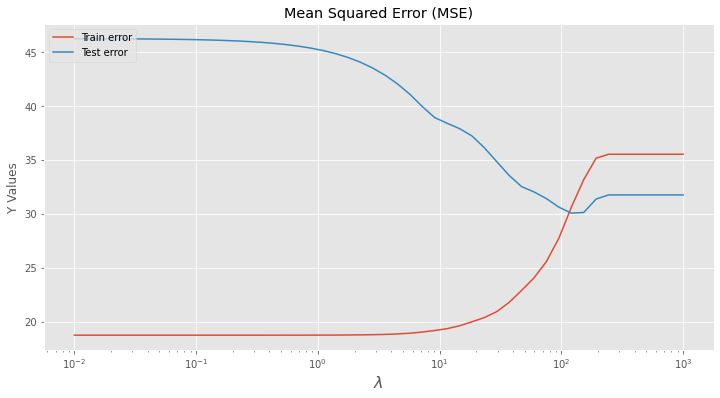

No handles with labels found to put in legend.


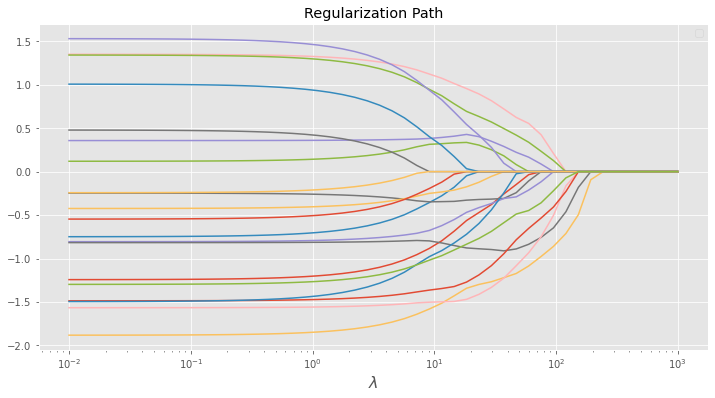

In [16]:
plot_train_test_errors(train_errors, test_errors, lambd_values)
plot_regularization_path(lambd_values, beta_values,feature_name=None)

# Find the Best Lambda for regularization 

In [22]:
minimum_test_error_index = test_errors.index(np.min(test_errors))
best_lambd               = np.round(list(lambd_values)[minimum_test_error_index],decimals=2)
best_lambd

120.68

In [26]:
model        = Regularizartion_Regression(x = X_train, y = Y_train ,lambd = best_lambd , norm_p =1)
prob,params  = model.optimize()

print("Objective Function Result : "     , prob.solve()                       )
print("Optimal Beta with best Lambda : " , np.round(params.value,decimals=5)  )

Objective Function Result :  1728.0988698327653
Optimal Beta with best Lambda :  [-0.       0.       0.      -0.      -0.       0.       0.       0.
  0.      -0.      -0.46175 -0.71196  0.      -0.16362 -0.22855 -0.
 -0.      -0.      -0.      -0.07159]


In [29]:
Best_Train_MSE = model.Mean_square_error(X_test  , Y_test  , np.round(params.value,decimals=5) )
Best_Test_MSE  = model.Mean_square_error(X_train , Y_train , np.round(params.value,decimals=5) )


print( "Best Lambda Train MSE : " , Best_Train_MSE   )
print( "Best Lambda Test  MSE : " , Best_Test_MSE    )

Best Lambda Train MSE :  30.07534212725729
Best Lambda Test  MSE :  30.609779625447104


# Elastic Net : (Lasso + Ridge)

In [30]:
class Elastic_Net():

    """
    x      --> Matrix with    (n,m)  ; n --> sample size ; m --> feature size
    y      --> predict vector (n,1)  ; n --> smaple size 
    beta   --> vector with    (m,1)  ; m --> feature size
    norm_p --> norm 1 --> lasso      ; norm 2 --> ridge 
    """

    def __init__(self,x,y,lambd):

        self.x = x 
        self.y = y 
        self.lambd = lambd
        self.beta  = cp.Variable(x.shape[1]) # number of feature

    def loss_function(self,x,y,beta):
        """
        Ordinary Least Square Loss Function 
        """
        return  cp.norm( x @ beta - y , 2 )**2

    def Objective_Function(self,x,y,beta,lambd):
        """
        OLSE Loss Function with regularization term
        """

        return  self.loss_function(x,y,beta) + lambd * self.regularizer(beta)

    def regularizer(self,beta):

        regular_term = cp.norm(beta,1) + cp.norm(beta,2) # With L1 Norm and L2 Norm

        return regular_term 

    def Mean_square_error(self,x,y,beta):
        
        n   = x.shape[0]
        mse = (1/n) * self.loss_function(x,y,beta).value
                
        return mse 
    
    def optimize(self):

        prob = cp.Problem( cp.Minimize(self.Objective_Function(self.x,self.y,self.beta,self.lambd)) )
  
        return prob ,self.beta

In [32]:
lambd_values = np.logspace(-2, 3, 50)
train_errors = []
test_errors  = []
beta_values  = []

In [33]:
for v in tqdm(lambd_values):
    
    model        = Elastic_Net(x = X_train, y = Y_train ,lambd = v )
    prob,params  = model.optimize()
    prob.solve()

    train_errors.append(model.Mean_square_error(X_train, Y_train, params.value))
    test_errors.append(model.Mean_square_error(X_test, Y_test, params.value))
    beta_values.append(params.value)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/chen-lichiang/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 50/50 [00:00<00:00, 109.57it/s]


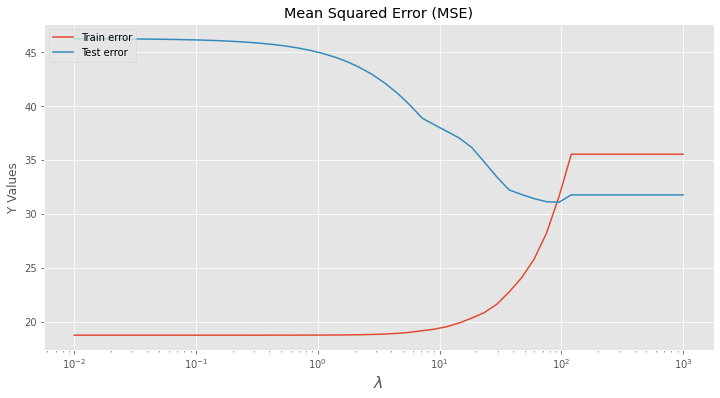

No handles with labels found to put in legend.


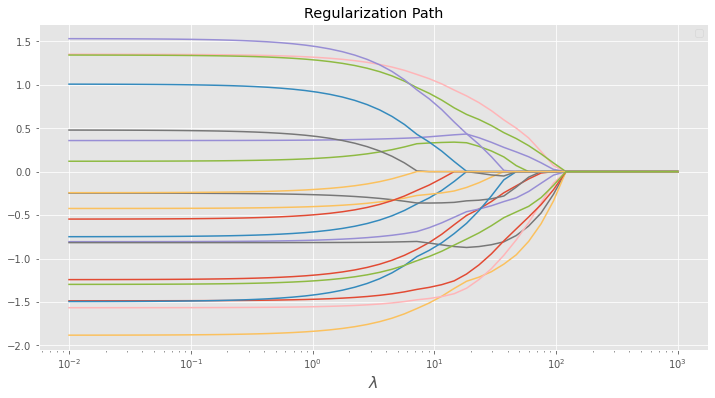

In [34]:
plot_train_test_errors(train_errors, test_errors, lambd_values)
plot_regularization_path(lambd_values, beta_values,feature_name=None)